### The system of chiral edge state coupling

In the paper, the lattice constant a=1 nm, and the Fermi energy is taken as E_F=3 meV.
However, if also use the magnetic topological insulator model for the leads, the E_F need to take values higher than about 8 meV to avoid the gap region in the small m cases.

In [1]:
import kwant
import numpy as np
import matplotlib.pyplot as plt
import tinyarray

sigma_0 = tinyarray.array([[1, 0], [0, 1]])
sigma_x = tinyarray.array([[0, 1], [1, 0]])
sigma_y = tinyarray.array([[0, -1j], [1j, 0]])
sigma_z = tinyarray.array([[1, 0], [0, -1]])

I_4= tinyarray.array(np.kron(sigma_0, sigma_0))
gamma_1 = tinyarray.array(np.kron(sigma_0, sigma_z))
gamma_2 = tinyarray.array(np.kron(sigma_z, sigma_z))
gamma_3 = tinyarray.array(np.kron(sigma_0, sigma_y))
gamma_4 = tinyarray.array(np.kron(sigma_0, sigma_x))

B=-300
g=300
las=1

structure=kwant.lattice.square(las)
model_sym= kwant.TranslationalSymmetry(structure.vec((-1,0)),structure.vec((0,-1)))

def onsite(site,m):
    return m/2*gamma_1 - (4*B)/las**2 * gamma_2

hopping_x = B/(las**2)*gamma_2 + 1j*g/(2*las)*gamma_3
hopping_y = B/(las**2)*gamma_2 - 1j*g/(2*las)*gamma_4

def model_MTI():
    model_1= kwant.Builder(model_sym)

    model_1[structure(0, 0)] = onsite
    model_1[kwant.builder.HoppingKind((1,0), structure)]  = hopping_x
    model_1[kwant.builder.HoppingKind((0,1), structure)]  = hopping_y

    return model_1

def model_EG():

    onsite_leads= 150 *I_4
    hopping_leads= -150 *I_4

    model_2= kwant.Builder(model_sym)
    model_2[structure(0, 0)] = onsite_leads
    model_2[structure.neighbors()]  = hopping_leads

    return model_2

def make_syst(width=50,length=100,leads_model=model_EG()):
    
    ########### create the scattering center

    def shape_center(site):
        x, y = site.pos
        return 0 < x <= length and 0 < y <= width

    syst= kwant.Builder()
    syst.fill(model_MTI(), shape_center,(1,1))

    ########### create the leads

    width_lead = length//5

    lead0= kwant.Builder(kwant.TranslationalSymmetry((-1,0)))
    lead1= kwant.Builder(kwant.TranslationalSymmetry((0,1)))
    lead2= kwant.Builder(kwant.TranslationalSymmetry((0,1)))

    def shape_lead0(site):
        x, y = site.pos
        return 0 < y <= width

    def shape_lead1(site):
        x, y = site.pos
        return width_lead < x <= 2*width_lead

    def shape_lead2(site):
        x, y = site.pos
        return 3*width_lead < x <= 4*width_lead

    lead0.fill(leads_model, shape_lead0, (0, 1))
    lead1.fill(leads_model, shape_lead1, (width_lead+1, 0))
    lead2.fill(leads_model, shape_lead2, (3*width_lead+1, 0))

    ########### create the six-terminal device
    for lead in [lead0,lead1,lead2, lead0.reversed(),lead2.reversed(),lead1.reversed()]:
        syst.attach_lead(lead)

    return syst.finalized()


c:\Users\23253\miniforge3\envs\xxy\lib\site-packages\kwant\lattice.py:746: KwantDeprecationWarning: Not specfying norbs is deprecated. Always specify norbs when creating site families.
  return Monatomic(((a, 0), (0, a)), name=name, norbs=norbs)


c:\Users\23253\miniforge3\envs\xxy\lib\site-packages\kwant\_plotter.py:77: RuntimeWarning: plotly is not available, if other engines are unavailable, only iterator-providing functions will work
  warnings.warn("plotly is not available, if other engines are unavailable,"


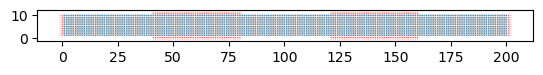

In [2]:
syst1=make_syst(width=10,length=200,leads_model=model_MTI())
kwant.plot(syst1);

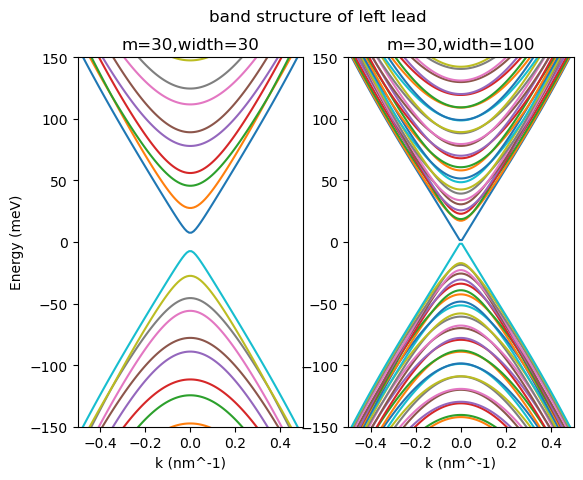

In [3]:
fig, (ax1,ax2) = plt.subplots(1,2)
fig.suptitle('band structure of left lead')

ax1.set_ylabel('Energy (meV)')
ax1.set_title('m=30,width=30')
ax2.set_title('m=30,width=100')
for ax in (ax1,ax2):
    ax.set_xlabel('k (nm^-1)')
    ax.set_ylim(-150,150)
    ax.set_xlim(-0.5,0.5)

syst1=make_syst(width=30,leads_model=model_MTI()).leads[0]
syst2=make_syst(width=100,leads_model=model_MTI()).leads[0]

kwant.plotter.bands(syst1,momenta=np.linspace(-0.5, 0.5, 100), ax=ax1, params=dict(m=30));
kwant.plotter.bands(syst2,momenta=np.linspace(-0.5, 0.5, 100), ax=ax2, params=dict(m=30));

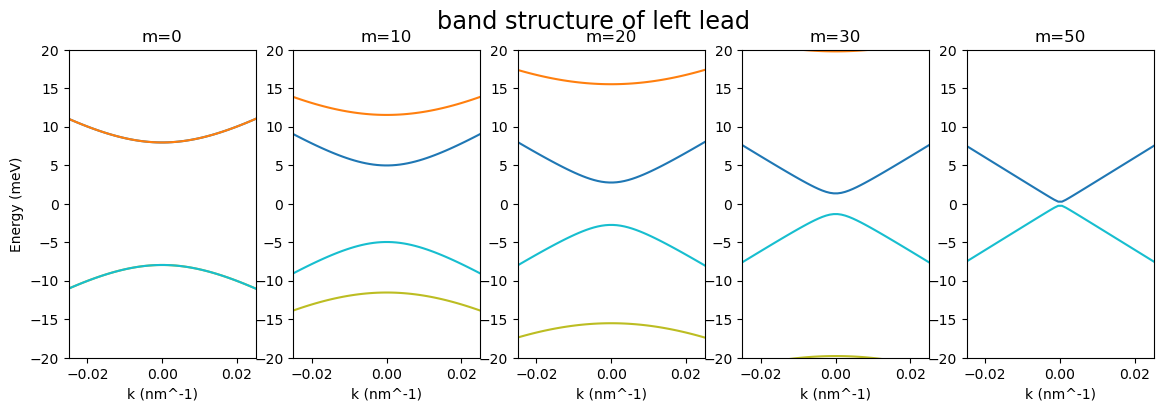

In [3]:
syst1=make_syst(width=60,leads_model=model_MTI()).leads[0]

fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize=(14, 4))
fig.suptitle('band structure of left lead', size='xx-large')
y_limit = 20
x_limit = 0.025
ax1.set_ylabel('Energy (meV)')
for ax in zip((ax1,ax2,ax3,ax4,ax5),(0,10,20,30,50)):
    ax[0].set_xlabel('k (nm^-1)')
    ax[0].set_ylim(-y_limit,y_limit)
    ax[0].set_xlim(-x_limit,x_limit)
    ax[0].set_title(f'm={ax[1]}')
    kwant.plotter.bands(syst1,momenta=np.linspace(-x_limit,x_limit , 50), ax=ax[0], params=dict(m=ax[1]));


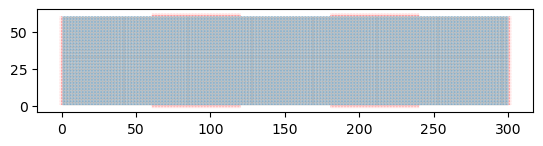

In [4]:
syst=make_syst(width=60,length=300,leads_model=model_MTI())
kwant.plot(syst);

In [5]:
tmatrix = kwant.smatrix(syst, 3.0,params=dict(m=30))
tm=tmatrix.conductance_matrix()
np.round(tm,2)

array([[ 0.94, -0.  , -0.  , -0.  , -0.05, -0.89],
       [-0.89,  0.94, -0.  , -0.  , -0.  , -0.05],
       [-0.05, -0.82,  0.94, -0.  , -0.07, -0.  ],
       [-0.  , -0.05, -0.89,  0.94, -0.  , -0.  ],
       [-0.  , -0.  , -0.05, -0.89,  0.94, -0.  ],
       [-0.  , -0.07, -0.  , -0.05, -0.82,  0.94]])

In [6]:
def find_voltages(tmatrix,current):
    try:
        voltage = np.linalg.solve(tmatrix[1:, 1:], current[1:])
    except np.linalg.LinAlgError as err:
        if 'Singular matrix' in str(err):
            print("Hi there, singular matrix here")
            voltage = [0,0,0,0,0]
        else:
            raise
    return [0, *voltage]

def resistance_xx(tmatrix):
    current = [1, 0, 0, -1, 0, 0]
    voltage = find_voltages(tmatrix,current)
    
    def resistance(lead1, lead2):
        return voltage[lead1-1]-voltage[lead2-1]

    return resistance(2, 3)

def resistance_xy(tmatrix):
    current = [1, 0, 0, -1, 0, 0]
    voltage = find_voltages(tmatrix,current)
    
    def resistance(lead1, lead2):
        return voltage[lead1-1]-voltage[lead2-1]

    return resistance(2, 6)

def rMplot(m_list, data, ptitle='resistance vs m'):
    rxx=[]
    rxy=[]
    for i in range(data.shape[0]):
        rxx.append(resistance_xx(data[i]))
        rxy.append(resistance_xy(data[i]))

    plt.plot(m_list,rxx,'-o', label='$R_{xx}$')
    plt.plot(m_list,rxy,'-o', label='$R_{xy}$')

    plt.title(ptitle, size='xx-large')
    plt.xlabel('m')
    plt.ylabel('Resistance')
    plt.legend()


# define a function to plot the resistance vs energy
# here, "data" is a "np.array", a list (different energy) of 6*6 transimission matrices=[]
def rEplot(energies, data, ptitle='resistance vs energy'):
    rxx=[]
    rxy=[]
    for i in range(data.shape[0]):
        rxx.append(resistance_xx(data[i]))
        rxy.append(resistance_xy(data[i]))

    plt.plot(energies,rxx,'-o', label='$R_{xx}$')
    plt.plot(energies,rxy,'-o', label='$R_{xy}$')

    plt.title(ptitle, size='xx-large')
    plt.xlabel('Energy')
    plt.ylabel('Resistance')
    plt.legend()



In [7]:
data=[]
m_range=np.linspace(-25,25,num=20)
for m_value in m_range:
    tmatrix = kwant.smatrix(syst, 9.0,params=dict(m=m_value))
    data.append(tmatrix.conductance_matrix())

# cost around 2 mins

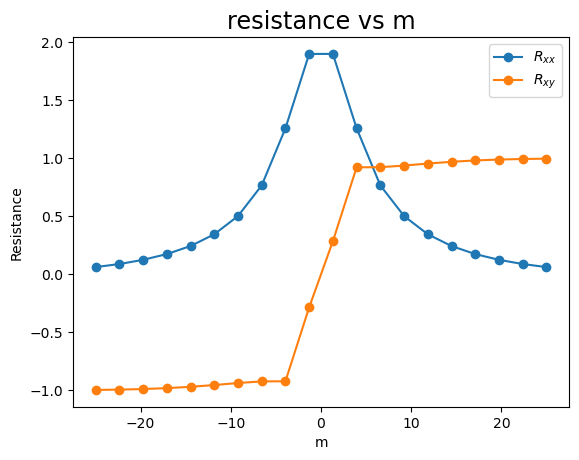

In [8]:
rMplot(m_range,np.array(data))

In [9]:
np.round(data[0],2)

array([[ 0.98, -0.96, -0.02, -0.  , -0.  , -0.  ],
       [-0.  ,  0.98, -0.91, -0.02, -0.  , -0.06],
       [-0.  , -0.  ,  0.98, -0.96, -0.02, -0.  ],
       [-0.  , -0.  , -0.  ,  0.98, -0.96, -0.02],
       [-0.02, -0.  , -0.06, -0.  ,  0.98, -0.91],
       [-0.96, -0.02, -0.  , -0.  , -0.  ,  0.98]])

In [10]:
np.round(data[3],2)

array([[ 0.95, -0.89, -0.05, -0.  , -0.  , -0.  ],
       [-0.  ,  0.95, -0.76, -0.05, -0.  , -0.14],
       [-0.  , -0.  ,  0.95, -0.89, -0.06, -0.  ],
       [-0.  , -0.  , -0.  ,  0.95, -0.89, -0.05],
       [-0.05, -0.  , -0.14, -0.  ,  0.95, -0.76],
       [-0.89, -0.06, -0.  , -0.  , -0.  ,  0.95]])

In [11]:
np.round(data[6],2)

array([[ 0.86, -0.76, -0.09, -0.01, -0.  , -0.  ],
       [-0.  ,  0.89, -0.49, -0.09, -0.  , -0.32],
       [-0.  , -0.  ,  0.89, -0.76, -0.13, -0.  ],
       [-0.01, -0.  , -0.  ,  0.86, -0.76, -0.09],
       [-0.09, -0.  , -0.32, -0.  ,  0.89, -0.49],
       [-0.76, -0.13, -0.  , -0.  , -0.  ,  0.89]])

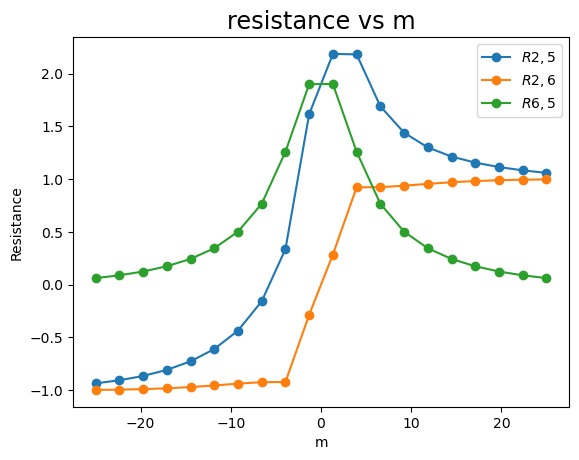

In [12]:
def rMplot_m(m_list, data, lead1=2,lead2=5, ptitle='resistance vs m'):
    current = [1, 0, 0, -1, 0, 0]
    rx=[]
    for i in range(data.shape[0]):
        voltage = find_voltages(data[i],current)
        rx.append(voltage[lead1-1]-voltage[lead2-1])

    plt.plot(m_list,rx,'-o', label=f'$R {lead1},{lead2}$')

    plt.title(ptitle, size='xx-large')
    plt.xlabel('m')
    plt.ylabel('Resistance')
    plt.legend()

rMplot_m(m_range,np.array(data),2,5)
rMplot_m(m_range,np.array(data),2,6)
rMplot_m(m_range,np.array(data),6,5)

In [13]:
syst=make_syst(width=60,length=300,leads_model=model_MTI())

In [14]:
data=[]
e_range=np.linspace(10,50,num=25)
for energy in e_range:
    tmatrix = kwant.smatrix(syst, energy,params=dict(m=50))
    data.append(tmatrix.conductance_matrix())

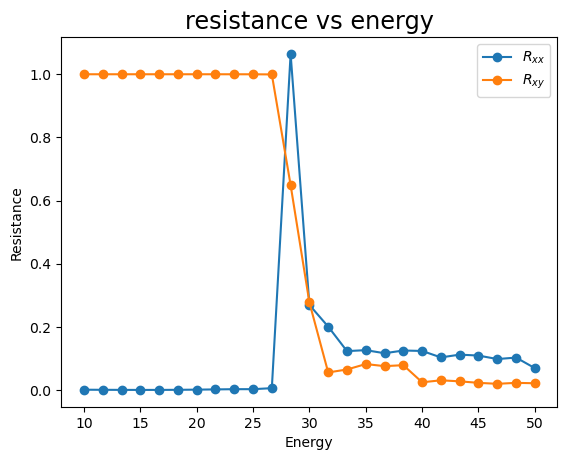

In [15]:
rEplot(e_range,np.array(data))

In [16]:
data=[]
e_range=np.linspace(0,15,num=20)
for energy in e_range:
    tmatrix = kwant.smatrix(syst, energy,params=dict(m=40))
    data.append(tmatrix.conductance_matrix())

Hi there, singular matrix here
Hi there, singular matrix here


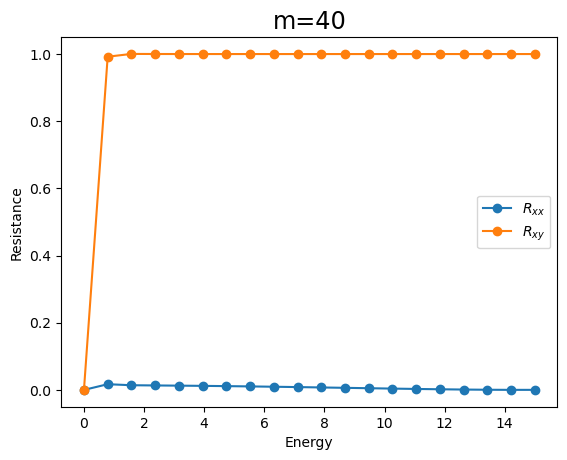

In [17]:
rEplot(e_range,np.array(data),"m=40")

somehow, the QSHE tranport signature does not show for m=0

compared to BZH model, the term Δ should be non-zero

In [18]:
data=[]
e_range=np.linspace(10,15,num=20)
for energy in e_range:
    tmatrix = kwant.smatrix(syst, energy,params=dict(m=0))
    data.append(tmatrix.conductance_matrix())

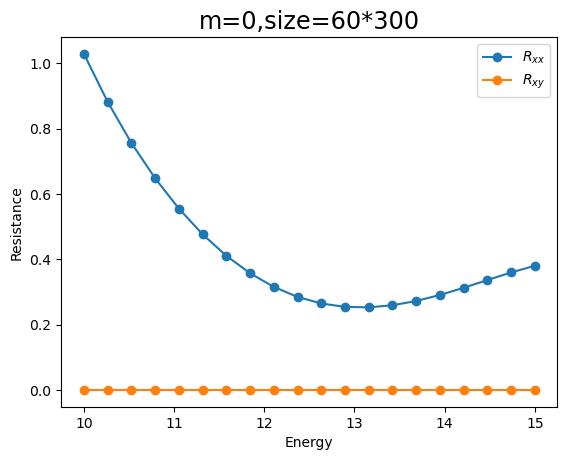

In [19]:
rEplot(e_range,np.array(data),"m=0,size=60*300")

In [20]:
syst100=make_syst(width=100,length=500,leads_model=model_MTI())

In [21]:
data100=[]
e_range=np.linspace(10,15,num=10)
for energy in e_range:
    tmatrix = kwant.smatrix(syst100, energy,params=dict(m=0))
    data100.append(tmatrix.conductance_matrix())

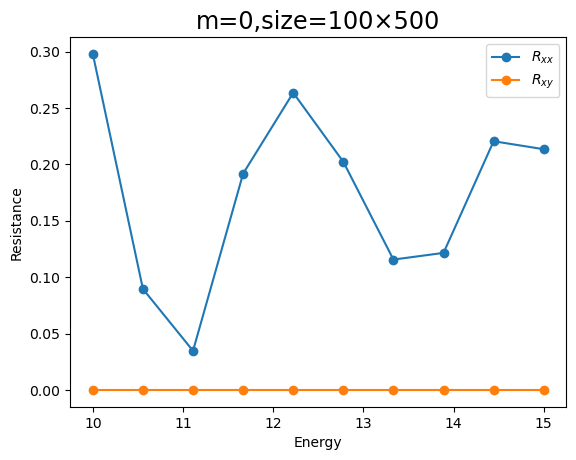

In [22]:
rEplot(e_range,np.array(data100),"m=0,size=100×500")

In [23]:
np.round(data[0],2)

array([[ 1.31, -0.54, -0.08, -0.07, -0.08, -0.54],
       [-0.54,  1.49, -0.18, -0.08, -0.  , -0.69],
       [-0.08, -0.18,  1.49, -0.54, -0.69, -0.  ],
       [-0.07, -0.08, -0.54,  1.31, -0.54, -0.08],
       [-0.08, -0.  , -0.69, -0.54,  1.49, -0.18],
       [-0.54, -0.69, -0.  , -0.08, -0.18,  1.49]])

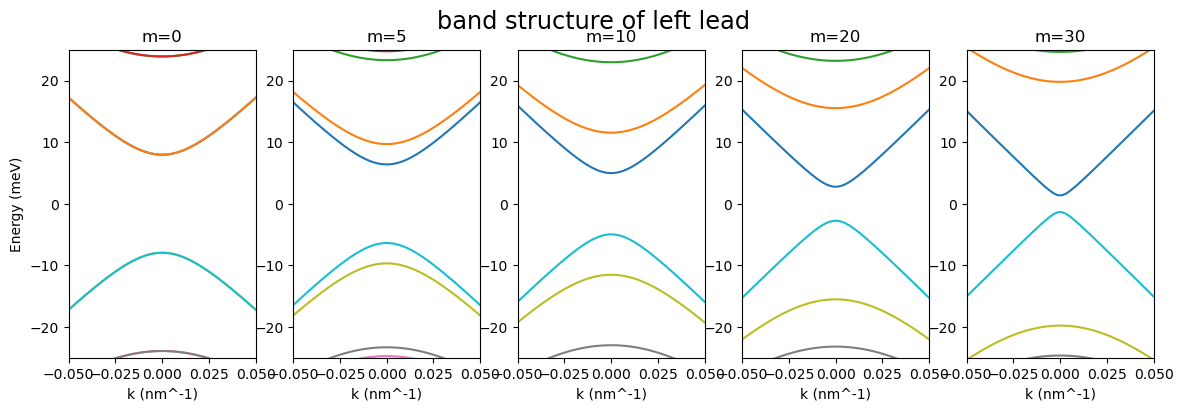

In [24]:
syst1=make_syst(width=60,leads_model=model_MTI()).leads[0]

fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize=(14, 4))
fig.suptitle('band structure of left lead', size='xx-large')

ax1.set_ylabel('Energy (meV)')
for ax in zip((ax1,ax2,ax3,ax4,ax5),(0,5,10,20,30)):
    ax[0].set_xlabel('k (nm^-1)')
    ax[0].set_ylim(-25,25)
    ax[0].set_xlim(-0.05,0.05)
    ax[0].set_title(f'm={ax[1]}')
    kwant.plotter.bands(syst1,momenta=np.linspace(-0.05, 0.05, 50), ax=ax[0], params=dict(m=ax[1]));


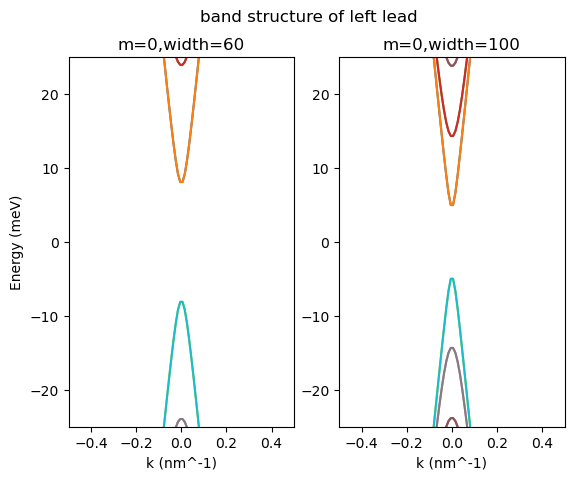

In [25]:
fig, (ax1,ax2) = plt.subplots(1,2)
fig.suptitle('band structure of left lead')

ax1.set_ylabel('Energy (meV)')
ax1.set_title('m=0,width=60')
ax2.set_title('m=0,width=100')
for ax in (ax1,ax2):
    ax.set_xlabel('k (nm^-1)')
    ax.set_ylim(-25,25)
    ax.set_xlim(-0.5,0.5)

syst1=make_syst(width=60,leads_model=model_MTI()).leads[0]
syst2=make_syst(width=100,leads_model=model_MTI()).leads[0]

kwant.plotter.bands(syst1,momenta=np.linspace(-0.5, 0.5, 100), ax=ax1, params=dict(m=0));
kwant.plotter.bands(syst2,momenta=np.linspace(-0.5, 0.5, 100), ax=ax2, params=dict(m=0));